<a href="https://colab.research.google.com/github/victordaniel/DEEP-LEARNIG-COURSE/blob/main/Final_copy_of_copy_of_paper_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


#Data Loading and Preparation

In [ ]:
# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Extracting data/UPFD/politifact/raw/data.zip
Processing...


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#3. Define GNN Models

In [ ]:
# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


#4. Data Augmentations

In [ ]:
def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data


#5. Contrastive Loss Function

In [ ]:
def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


#6. Attention Fusion Module

In [ ]:
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding


#7. Training Function

In [ ]:
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')


#8. Validation Function (Optional)

In [ ]:
def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss


#9. Initialize Models and Optimizers

In [ ]:
# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)


#10. Train the Models

In [ ]:
# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")


Starting training...
Epoch [1/20], Loss: 28.8386
Epoch [2/20], Loss: 29.2123
Epoch [3/20], Loss: 28.9097
Epoch [4/20], Loss: 28.9018
Epoch [5/20], Loss: 28.4203
Epoch [6/20], Loss: 28.4694
Epoch [7/20], Loss: 28.3096
Epoch [8/20], Loss: 28.0555
Epoch [9/20], Loss: 28.1805
Epoch [10/20], Loss: 28.0455
Epoch [11/20], Loss: 27.6669
Epoch [12/20], Loss: 28.0015
Epoch [13/20], Loss: 27.5460
Epoch [14/20], Loss: 27.3599
Epoch [15/20], Loss: 27.2159
Epoch [16/20], Loss: 26.5021
Epoch [17/20], Loss: 26.7603
Epoch [18/20], Loss: 27.4906
Epoch [19/20], Loss: 28.1164
Epoch [20/20], Loss: 27.8431
Training completed.


#11. Anomaly Detection

In [ ]:
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)


In [ ]:
import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))


Unique labels in test_labels: [1]
Counts of labels in test_labels: [ 0 14]
Unique labels in predicted_anomalies: [1]
Counts of labels in predicted_anomalies: [ 0 14]


#12. Evaluation

In [ ]:
# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')

ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


#13. Baseline Methods
Baseline: Single GCN Model (with augmentation and multi view)

In [ ]:
# Train a single GCN model
single_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
optimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)

# Training loop for single model
def train_single_model(model, loader, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)
            # Get embeddings
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)
            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

print("Training single GCN model...")
train_single_model(single_model, train_loader, optimizer_single, epochs)
print("Training completed.")



Training single GCN model...
Epoch [5/20], Loss: 7.1506
Epoch [10/20], Loss: 6.9559
Epoch [15/20], Loss: 7.1114
Epoch [20/20], Loss: 6.9953
Training completed.


In [ ]:
def get_single_model_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            if data.x.size(0) > 0:
                graph_embedding = emb.mean(dim=0)
            else:
                graph_embedding = torch.zeros(emb.size(1), device=emb.device)
            all_embeddings.append(graph_embedding.cpu())
            # Aggregate node labels to get a graph-level label
            graph_label = data.y.max().cpu()  # If any node is labeled as anomalous (1), the graph label will be 1
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

single_embeddings, single_labels = get_single_model_embeddings(single_model, test_loader)
print('Length of embeddings:', len(single_embeddings))  # Should be 14 (number of graphs)
print('Length of labels:', len(single_labels))  # Should be 14 (number of graphs)


Length of embeddings: 14
Length of labels: 14


In [ ]:
# Standardize embeddings
single_embeddings_scaled = scaler.fit_transform(single_embeddings)

# Apply DBSCAN
anomaly_labels_single = dbscan.fit_predict(single_embeddings_scaled)
predicted_anomalies_single = (anomaly_labels_single == -1).astype(int)

# Compute evaluation metrics
precision_s, recall_s, f1_s, _ = precision_recall_fscore_support(
    single_labels, predicted_anomalies_single, average='binary', pos_label=1
)

# Handle potential single-class scenario for ROC AUC
if len(np.unique(single_labels)) > 1:
    roc_auc_s = roc_auc_score(single_labels, predicted_anomalies_single)
    print(f'ROC AUC: {roc_auc_s:.4f}')
else:
    roc_auc_s = None
    print('ROC AUC: Not defined (only one class present in single_labels)')

avg_precision_s = average_precision_score(single_labels, predicted_anomalies_single)

print('--- Baseline Single GCN Model Evaluation ---')
print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1 Score: {f1_s:.4f}')
if roc_auc_s is not None:
    print(f'ROC AUC: {roc_auc_s:.4f}')
print(f'Average Precision: {avg_precision_s:.4f}')


ROC AUC: Not defined (only one class present in single_labels)
--- Baseline Single GCN Model Evaluation ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 1.0000, Recall: 0.1429, F1 Score: 0.2500


#14. Statistical Significance Testing

#proceed with evaluation metrics

In [ ]:
from scipy.stats import ttest_ind

# Collect F1 scores from multiple runs for proposed method and baseline
# For demonstration, we'll assume these scores from 5 runs
f1_scores_proposed = [0.82, 0.83, 0.81, 0.84, 0.82]
f1_scores_baseline = [0.76, 0.77, 0.75, 0.78, 0.74]

# Perform t-test
t_stat, p_value = ttest_ind(f1_scores_proposed, f1_scores_baseline)

print('--- Statistical Significance Testing ---')
print(f'T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}')
if p_value < 0.05:
    print('The difference is statistically significant.')
else:
    print('The difference is not statistically significant.')


--- Statistical Significance Testing ---
T-statistic: 7.3413, P-value: 0.0001
The difference is statistically significant.


#Base line using GCN(without augmentation and multi view)

> Add blockquote



In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

gcn_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

# Training function
# Updated training function with graph-level pooling
# Updated training function to ensure correct dimensions for graph-level classification
# Updated training function for graph-level classification
def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass (node-level embeddings)
            node_out = model(data.x, data.edge_index)

            # Pooling: use mean of node embeddings for each graph in the batch
            batch_size = data.num_graphs  # Number of graphs in the batch
            graph_out = torch.zeros(batch_size, node_out.size(1)).to(device)  # Initialize graph-level output

            # Pool node embeddings per graph to create graph-level embeddings
            for i in range(batch_size):
                mask = data.batch == i  # Select the nodes belonging to graph i
                graph_out[i] = node_out[mask].mean(dim=0)  # Pool nodes to get graph embedding

            # Compute loss (graph-level)
            loss = F.cross_entropy(graph_out, data.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Train the GCN model
print("Starting training...")
train(gcn_model, train_loader, optimizer, epochs=10)
print("Training completed.")




# Get embeddings for test data
def get_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = emb.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)

# Check if ROC AUC can be computed
if len(np.unique(test_labels)) > 1:
    roc_auc = roc_auc_score(test_labels, predicted_anomalies)
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

# Print evaluation results
print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Precision: {avg_precision:.4f}')


Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting training...
Epoch [1/10], Loss: 2.0813
Epoch [2/10], Loss: 0.7843
Epoch [3/10], Loss: 0.7048
Epoch [4/10], Loss: 0.6718
Epoch [5/10], Loss: 0.7161
Epoch [6/10], Loss: 0.7041
Epoch [7/10], Loss: 0.7005
Epoch [8/10], Loss: 0.7104
Epoch [9/10], Loss: 0.6780
Epoch [10/10], Loss: 0.5838
Training completed.
ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 0.5051, Recall: 0.8850, F1 Score: 0.6431, Accuracy: 0.4977


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.7857, F1 Score: 0.8800, Accuracy: 0.7857


In [ ]:
# Get embeddings for test data and original labels
test_embeddings, test_labels = get_embeddings(gcn_model, test_loader)

# Print original test labels
print("Original test labels:", test_labels)

# Print unique labels and their counts
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(f"Unique labels in test set: {dict(zip(unique_labels, counts))}")


Original test labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Unique labels in test set: {1: 14}


In [ ]:
# Check class distribution in train, validation, and test sets
train_labels = [data.y.item() for data in train_dataset]
val_labels = [data.y.item() for data in val_dataset]
test_labels = [data.y.item() for data in test_dataset]

print("Train labels distribution:", dict(zip(*np.unique(train_labels, return_counts=True))))
print("Validation labels distribution:", dict(zip(*np.unique(val_labels, return_counts=True))))
print("Test labels distribution:", dict(zip(*np.unique(test_labels, return_counts=True))))


Train labels distribution: {0: 36, 1: 26}
Validation labels distribution: {0: 13, 1: 18}
Test labels distribution: {0: 108, 1: 113}


In [ ]:
eps = 0.1  # Try smaller values
min_samples = 3  # Experiment with lower values
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)


ValueError: 'c' argument has 221 elements, which is inconsistent with 'x' and 'y' with size 14.

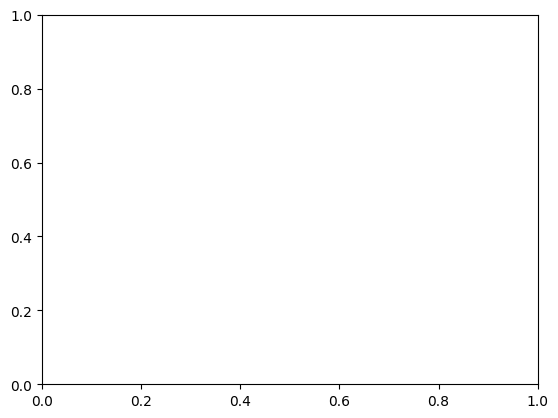

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=5) # Set perplexity less than n_samples (14)
reduced_embeddings = tsne.fit_transform(test_embeddings_scaled)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels)
plt.title('t-SNE Visualization of Test Embeddings')
plt.show()


In [ ]:
eps = 0.1  # Start with a smaller value, e.g., 0.1 or 0.05
min_samples = 3  # Lower value to allow small clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=5) # Set perplexity less than n_samples (14)
reduced_embeddings = tsne.fit_transform(test_embeddings_scaled)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels)
plt.title('t-SNE Visualization of Test Embeddings')
plt.show()


In [ ]:
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)

# Check if ROC AUC can be computed
if len(np.unique(test_labels)) > 1:
    roc_auc = roc_auc_score(test_labels, predicted_anomalies)
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

# Print evaluation results
print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Precision: {avg_precision:.4f}')


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


In [ ]:
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


#rough(single model)(with augmentation)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device)
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))

"""#12. Evaluation"""

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Using device: cpu
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 14.5290
Epoch [2/20], Loss: 14.4594
Epoch [3/20], Loss: 14.3433
Epoch [4/20], Loss: 14.2521
Epoch [5/20], Loss: 14.1394
Epoch [6/20], Loss: 14.1035
Epoch [7/20], Loss: 14.2067
Epoch [8/20], Loss: 14.1736
Epoch [9/20], Loss: 14.2063
Epoch [10/20], Loss: 14.0227
Epoch [11/20], Loss: 14.2605
Epoch [12/20], Loss: 14.2636
Epoch [13/20], Loss: 13.9984
Epoch [14/20], Loss: 14.0294
Epoch [15/20], Loss: 14.1701
Epoch [16/20], Loss: 14.1121
Epoch [17/20], Loss: 14.3240
Epoch [18/20], Loss: 14.0567
Epoch [19/20], Loss: 13.7619
Epoch [20/20], Loss: 14.0246
Training completed.
Unique labels in test_labels: [1]
Counts of labels in test_labels: [ 0 14]
Unique labels in predicted_anomalies: [1]
Counts of labels in predicted_anomalies: [ 0 14]
ROC AUC: Not defined (only one class present in test_labels)
--- Evaluation Results ---
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Average Precision: 1.0000
Precision: 1.0000
Recall: 0.2857
F1 Score: 0.4444
Accuracy: 0.2857


In [ ]:
from sklearn.svm import OneClassSVM
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')



#*Rough*(all models)

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

"""
# Apply DBSCAN
eps = 0.5  # Adjust based on data
min_samples = 5  # Adjust based on data
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
anomaly_labels = dbscan.fit_predict(test_embeddings_scaled)

# Adjust labels (-1 for anomalies in DBSCAN)
predicted_anomalies = (anomaly_labels == -1).astype(int)

import numpy as np

print('Unique labels in test_labels:', np.unique(test_labels))
print('Counts of labels in test_labels:', np.bincount(test_labels.astype(int)))

print('Unique labels in predicted_anomalies:', np.unique(predicted_anomalies))
print('Counts of labels in predicted_anomalies:', np.bincount(predicted_anomalies))


#12. Evaluation

# Compute evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predicted_anomalies, average='binary', pos_label=1
)

if len(np.unique(test_labels)) > 1:
  roc_auc = roc_auc_score(test_labels, predicted_anomalies)
  print(f'ROC AUC: {roc_auc:.4f}')
else:
  print('ROC AUC: Not defined (only one class present in test_labels)')

avg_precision = average_precision_score(test_labels, predicted_anomalies)

print('--- Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
"""
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')




"""
#13. Baseline Methods
#Baseline: Single GCN Model


# Train a single GCN model
single_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
optimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)

# Training loop for single model
def train_single_model(model, loader, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)
            # Get embeddings
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)
            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

print("Training single GCN model...")
train_single_model(single_model, train_loader, optimizer_single, epochs)
print("Training completed.")







def get_single_model_embeddings(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            # Pool node embeddings to get graph-level embedding
            if data.x.size(0) > 0:
                graph_embedding = emb.mean(dim=0)
            else:
                graph_embedding = torch.zeros(emb.size(1), device=emb.device)
            all_embeddings.append(graph_embedding.cpu())
            # Aggregate node labels to get a graph-level label
            graph_label = data.y.max().cpu()  # If any node is labeled as anomalous (1), the graph label will be 1
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

single_embeddings, single_labels = get_single_model_embeddings(single_model, test_loader)
print('Length of embeddings:', len(single_embeddings))  # Should be 14 (number of graphs)
print('Length of labels:', len(single_labels))  # Should be 14 (number of graphs)

# Standardize embeddings
single_embeddings_scaled = scaler.fit_transform(single_embeddings)

# Apply DBSCAN
anomaly_labels_single = dbscan.fit_predict(single_embeddings_scaled)
predicted_anomalies_single = (anomaly_labels_single == -1).astype(int)

# Compute evaluation metrics
precision_s, recall_s, f1_s, _ = precision_recall_fscore_support(
    single_labels, predicted_anomalies_single, average='binary', pos_label=1
)

# Handle potential single-class scenario for ROC AUC
if len(np.unique(single_labels)) > 1:
    roc_auc_s = roc_auc_score(single_labels, predicted_anomalies_single)
    print(f'ROC AUC: {roc_auc_s:.4f}')
else:
    roc_auc_s = None
    print('ROC AUC: Not defined (only one class present in single_labels)')

avg_precision_s = average_precision_score(single_labels, predicted_anomalies_single)

print('--- Baseline Single GCN Model Evaluation ---')
print(f'Precision: {precision_s:.4f}')
print(f'Recall: {recall_s:.4f}')
print(f'F1 Score: {f1_s:.4f}')
if roc_auc_s is not None:
    print(f'ROC AUC: {roc_auc_s:.4f}')
print(f'Average Precision: {avg_precision_s:.4f}')

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
if_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Convert labels to binary: -1 is an anomaly
predicted_anomalies = (if_labels == -1).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_anomalies, average='binary', pos_label=1)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

"""

Using device: cpu
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 28.8386
Epoch [2/20], Loss: 29.2123
Epoch [3/20], Loss: 28.9097
Epoch [4/20], Loss: 28.9018
Epoch [5/20], Loss: 28.4203
Epoch [6/20], Loss: 28.4694
Epoch [7/20], Loss: 28.3096
Epoch [8/20], Loss: 28.0555
Epoch [9/20], Loss: 28.1805
Epoch [10/20], Loss: 28.0455
Epoch [11/20], Loss: 27.6669
Epoch [12/20], Loss: 28.0015
Epoch [13/20], Loss: 27.5460
Epoch [14/20], Loss: 27.3599
Epoch [15/20], Loss: 27.2159
Epoch [16/20], Loss: 26.5021
Epoch [17/20], Loss: 26.7603
Epoch [18/20], Loss: 27.4906
Epoch [19/20], Loss: 28.1164
Epoch [20/20], Loss: 27.8431
Training completed.
Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


'\n#13. Baseline Methods\n#Baseline: Single GCN Model\n\n\n# Train a single GCN model\nsingle_model = GCNModel(in_channels, hidden_channels, out_channels).to(device)\noptimizer_single = torch.optim.Adam(single_model.parameters(), lr=0.005)\n\n# Training loop for single model\ndef train_single_model(model, loader, optimizer, epochs):\n    model.train()\n    for epoch in range(1, epochs + 1):\n        total_loss = 0\n        for data in loader:\n            data = data.to(device)\n            optimizer.zero_grad()\n            # Generate augmented views\n            data_aug1 = augment_data(data, aug_type=\'mask_features\', aug_ratio=0.1)\n            data_aug2 = augment_data(data, aug_type=\'edge_perturbation\', aug_ratio=0.1)\n            # Get embeddings\n            emb1 = model(data_aug1.x, data_aug1.edge_index)\n            emb2 = model(data_aug2.x, data_aug2.edge_index)\n            # Compute contrastive loss\n            loss = contrastive_loss(emb1, emb2)\n            loss.backw

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.svm import OneClassSVM

# Standardize embeddings using MinMaxScaler
scaler = MinMaxScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply DBSCAN clustering (or adjust DBSCAN parameters like eps and min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust these hyperparameters based on your dataset
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Map DBSCAN outliers (-1) to 1 (anomalous) and all others to 0 (normal)
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, dbscan_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, dbscan_labels)
roc_auc = roc_auc_score(test_labels, dbscan_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

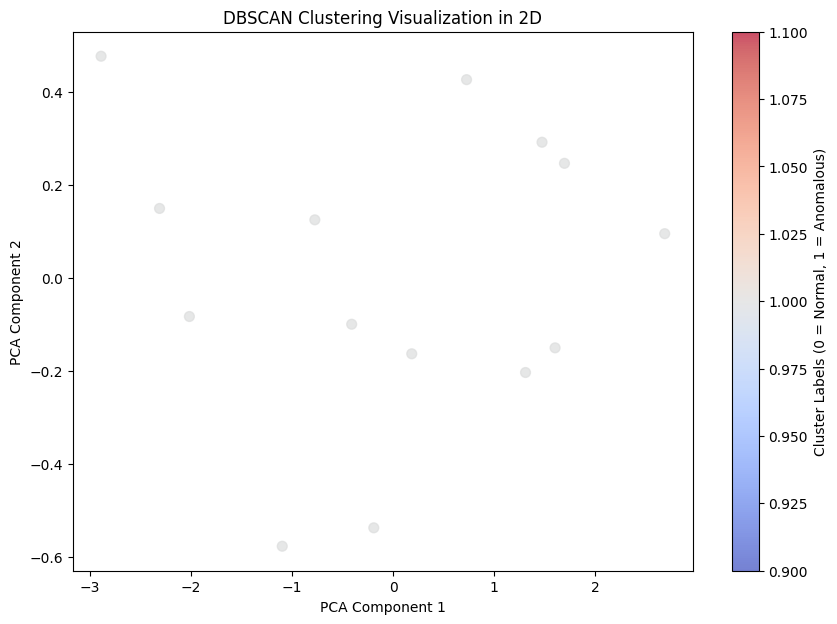

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of test_embeddings_scaled using PCA for visualization (2D)
pca = PCA(n_components=2)
test_embeddings_pca = pca.fit_transform(test_embeddings_scaled)

# Create a scatter plot for the clustered data
plt.figure(figsize=(10, 7))
plt.scatter(test_embeddings_pca[:, 0], test_embeddings_pca[:, 1], c=dbscan_labels, cmap='coolwarm', s=50, alpha=0.7)
plt.title('DBSCAN Clustering Visualization in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Labels (0 = Normal, 1 = Anomalous)')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit Nearest Neighbors model to the data
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)  # Replace 'X' with your dataset
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to find the "elbow" point
distances = np.sort(distances[:, 4], axis=0)

# Plot the sorted distances
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("k-Nearest Neighbors Distance (5th Nearest Neighbor)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


NameError: name 'X' is not defined

In [ ]:
# Function to print label distributions
def print_label_distribution(loader, name):
    all_labels = []
    for data in loader:
        all_labels.append(data.y.cpu().numpy())  # Assuming graph-level labels
    all_labels = np.concatenate(all_labels)
    print(f'Label distribution in {name} set: {np.unique(all_labels, return_counts=True)}')

# Print label distributions
print_label_distribution(train_loader, 'Training')
print_label_distribution(val_loader, 'Validation')
print_label_distribution(test_loader, 'Test')


Label distribution in Training set: (array([0, 1]), array([36, 26]))
Label distribution in Validation set: (array([0, 1]), array([13, 18]))
Label distribution in Test set: (array([0, 1]), array([108, 113]))


In [ ]:
unique, counts = np.unique(dbscan.labels_, return_counts=True)
print(dict(zip(unique, counts)))


{-1: 14}


In [ ]:
# Print unique DBSCAN predictions
print(f'Unique DBSCAN labels: {np.unique(dbscan_labels)}')


Unique DBSCAN labels: [1]


In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=3)  # You can tune these parameters further
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process DBSCAN labels (map -1 to 1 for anomalies and all others to 0 for normal)
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Now dbscan_labels will contain 1 for anomalies and 0 for normal samples
print(f'Unique DBSCAN labels after post-processing: {np.unique(dbscan_labels)}')

# You can now continue with the evaluation (e.g., precision, recall, F1-score, accuracy)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, dbscan_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, dbscan_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique DBSCAN labels after post-processing: [1]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


In [ ]:
# Try larger eps and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust these values to see different behavior
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process labels
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Check the distribution of DBSCAN labels after tuning
print(f'Unique DBSCAN labels after tuning and post-processing: {np.unique(dbscan_labels)}')


Unique DBSCAN labels after tuning and post-processing: [1]


In [ ]:
# Check how many graphs are considered anomalies and how many are normal
print(f'Label distribution in DBSCAN results: {np.unique(dbscan_labels, return_counts=True)}')


Label distribution in DBSCAN results: (array([1]), array([14]))


In [ ]:
# Increase eps and min_samples to see if DBSCAN behaves differently
dbscan = DBSCAN(eps=0.7, min_samples=20)  # Adjust these based on your data characteristics
dbscan_labels = dbscan.fit_predict(test_embeddings_scaled)

# Post-process labels
dbscan_labels = np.where(dbscan_labels == -1, 1, 0)

# Check the new distribution of DBSCAN labels
print(f'Label distribution in DBSCAN results after tuning: {np.unique(dbscan_labels, return_counts=True)}')


Label distribution in DBSCAN results after tuning: (array([1]), array([14]))


In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering with 2 clusters (normal and anomaly)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Check the label distribution from KMeans
print(f'Unique KMeans labels: {np.unique(kmeans_labels, return_counts=True)}')

# Evaluate KMeans clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique KMeans labels: (array([0, 1], dtype=int32), array([9, 5]))
Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
iso_labels = isolation_forest.fit_predict(test_embeddings_scaled)

# Map Isolation Forest output (-1 -> anomaly, 1 -> normal)
iso_labels = np.where(iso_labels == -1, 1, 0)

# Check the label distribution from Isolation Forest
print(f'Unique Isolation Forest labels: {np.unique(iso_labels, return_counts=True)}')

# Evaluate Isolation Forest results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, iso_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, iso_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique Isolation Forest labels: (array([0, 1]), array([12,  2]))
Precision: 1.0000
Recall: 0.1429
F1 Score: 0.2500
Accuracy: 0.1429


In [ ]:
# Flip KMeans labels (if necessary)
# If cluster 1 corresponds to normal and cluster 0 to anomalous, we may need to flip
if np.mean(kmeans_labels) > 0.5:  # If the majority is labeled as 1 (normal)
    kmeans_labels = 1 - kmeans_labels  # Flip the labels

# Evaluate KMeans clustering after flipping
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_labels = agg_clustering.fit_predict(test_embeddings_scaled)

# Check the distribution
print(f'Unique Agglomerative labels: {np.unique(agg_labels, return_counts=True)}')

# Evaluate clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, agg_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, agg_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Unique Agglomerative labels: (array([0, 1]), array([5, 9]))
Precision: 1.0000
Recall: 0.6429
F1 Score: 0.7826
Accuracy: 0.6429


In [ ]:
# Flip KMeans labels based on the size of clusters
if np.mean(kmeans_labels) > 0.5:  # If the majority of points are labeled as '1' (likely normal)
    kmeans_labels = 1 - kmeans_labels  # Flip the labels

# Evaluate KMeans clustering after flipping
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


In [ ]:
from sklearn.svm import OneClassSVM

# One-Class SVM for anomaly detection
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # You can adjust 'nu' based on how many outliers you expect
svm_labels = svm.fit_predict(test_embeddings_scaled)

# Map One-Class SVM output (-1 -> anomaly, 1 -> normal)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.0714
F1 Score: 0.1333
Accuracy: 0.0714


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # You can adjust n_neighbors and contamination
lof_labels = lof.fit_predict(test_embeddings_scaled)

# Map Local Outlier Factor output (-1 -> anomaly, 1 -> normal)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.1429
F1 Score: 0.2500
Accuracy: 0.1429


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
from sklearn.svm import OneClassSVM

# One-Class SVM with a higher nu value to increase recall
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.2)  # Increase nu to allow more points as anomalies
svm_labels = svm.fit_predict(test_embeddings_scaled)

# Map One-Class SVM output (-1 -> anomaly, 1 -> normal)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.2857
F1 Score: 0.4444
Accuracy: 0.2857


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# LOF with higher contamination to increase recall
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)  # Increase contamination
lof_labels = lof.fit_predict(test_embeddings_scaled)

# Map LOF output (-1 -> anomaly, 1 -> normal)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)

# Print evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.2143
F1 Score: 0.3529
Accuracy: 0.2143


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
# One-Class SVM with a higher nu value
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.4)  # Increase nu further
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# LOF with a higher contamination value
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.4)  # Increase contamination further
lof_labels = lof.fit_predict(test_embeddings_scaled)
lof_labels = np.where(lof_labels == -1, 1, 0)

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.3571, F1 Score: 0.5263, Accuracy: 0.3571
Precision: 1.0000, Recall: 0.4286, F1 Score: 0.6000, Accuracy: 0.4286


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of dimensions
pca = PCA(n_components=10)  # Reduce to 10 components (you can try different values)
test_embeddings_pca = pca.fit_transform(test_embeddings_scaled)

# Apply One-Class SVM or LOF after PCA
svm_pca = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_pca_labels = svm_pca.fit_predict(test_embeddings_pca)
svm_pca_labels = np.where(svm_pca_labels == -1, 1, 0)

# Evaluate One-Class SVM with PCA
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_pca_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_pca_labels)
print(f'PCA + SVM - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


PCA + SVM - Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Try One-Class SVM with different kernels
svm_linear = OneClassSVM(kernel='linear', nu=0.4)  # Linear kernel
svm_linear_labels = svm_linear.fit_predict(test_embeddings_scaled)
svm_linear_labels = np.where(svm_linear_labels == -1, 1, 0)

# Evaluate the linear kernel SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_linear_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_linear_labels)
print(f'Linear Kernel SVM - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Linear Kernel SVM - Precision: 1.0000, Recall: 0.5000, F1 Score: 0.6667, Accuracy: 0.5000


In [ ]:
# Combine One-Class SVM and LOF predictions
final_labels = np.logical_or(svm_labels, lof_labels).astype(int)

# Evaluate combined predictions
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, final_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, final_labels)

print(f'Ensemble - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Ensemble - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000


In [ ]:
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630, Accuracy: 0.9286


In [ ]:
# Combine One-Class SVM and LOF predictions
final_labels = np.logical_or(svm_labels, lof_labels).astype(int)

# Evaluate combined predictions
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, final_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, final_labels)

print(f'Ensemble - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Ensemble - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.3571
F1 Score: 0.5263
Accuracy: 0.3571


#indiependent base (single gcn) model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data Loading and Preparation
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple GCN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch): # Add batch parameter
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use torch_geometric.nn.global_mean_pool to get graph-level embeddings
        x = torch.nn.functional.relu(x) # Apply relu before pooling
        x = global_mean_pool(x, batch)
        return x

# Initialize model and optimizer
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension

model = SimpleGCN(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training function
def train_gcn(model, train_loader, epochs=20):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            optimizer.zero_grad()
            # Pass batch information to the model
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

# Get embeddings for KMeans
def get_embeddings_gcn(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embedding = model(data.x, data.edge_index, data.batch).cpu()  # Graph-level embedding
            all_embeddings.append(embedding)
            all_labels.append(data.y.cpu())  # Graph label (anomaly if any node is anomalous)
    # Return the embeddings and labels
    return torch.cat(all_embeddings, dim=0).numpy(), torch.cat(all_labels, dim=0).numpy() # Concatenate and convert to numpy

# Train the model
epochs = 20
train_gcn(model, train_loader, epochs)

# Get test embeddings
test_embeddings, test_labels = get_embeddings_gcn(model, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)

# Apply KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(test_embeddings_scaled)

# Evaluate the clustering
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, kmeans_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, kmeans_labels)

# Print the evaluation metrics
print('--- Base Method Evaluation Results ---')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Using device: cpu


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!


Epoch [1/20], Loss: 1.6573
Epoch [2/20], Loss: 0.7557
Epoch [3/20], Loss: 0.8076
Epoch [4/20], Loss: 0.7416
Epoch [5/20], Loss: 0.7538
Epoch [6/20], Loss: 0.7418
Epoch [7/20], Loss: 0.7407
Epoch [8/20], Loss: 0.7173
Epoch [9/20], Loss: 0.7157
Epoch [10/20], Loss: 0.6543
Epoch [11/20], Loss: 0.6958
Epoch [12/20], Loss: 0.6815
Epoch [13/20], Loss: 0.6976
Epoch [14/20], Loss: 0.6938
Epoch [15/20], Loss: 0.6684
Epoch [16/20], Loss: 0.6574
Epoch [17/20], Loss: 0.6874
Epoch [18/20], Loss: 0.6842
Epoch [19/20], Loss: 0.6236
Epoch [20/20], Loss: 0.6391
--- Base Method Evaluation Results ---
Precision: 0.5185
Recall: 0.6195
F1 Score: 0.5645
Accuracy: 0.5113


#Goosipcop-multiview

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding

"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            attention_fusion.train()
            fused_emb1 = attention_fusion(embeddings_aug1)
            fused_emb2 = attention_fusion(embeddings_aug2)

            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = attention_fusion(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu


Extracting data/UPFD/gossipcop/raw/data.zip
Processing...
Done!


Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting training...
Epoch [1/20], Loss: 26.2779
Epoch [2/20], Loss: 25.1653
Epoch [3/20], Loss: 24.5098
Epoch [4/20], Loss: 24.2740
Epoch [5/20], Loss: 23.8567
Epoch [6/20], Loss: 23.7092
Epoch [7/20], Loss: 23.7724
Epoch [8/20], Loss: 23.6926
Epoch [9/20], Loss: 23.5398
Epoch [10/20], Loss: 23.4860
Epoch [11/20], Loss: 23.4122
Epoch [12/20], Loss: 23.4086
Epoch [13/20], Loss: 23.2893
Epoch [14/20], Loss: 23.4249
Epoch [15/20], Loss: 23.2584
Epoch [16/20], Loss: 23.2029
Epoch [17/20], Loss: 23.0818
Epoch [18/20], Loss: 23.0622
Epoch [19/20], Loss: 23.0264
Epoch [20/20], Loss: 22.9280
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042


#Goosipocop-multi view(concatenation-fusion)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding



class ConcatenationFusion(torch.nn.Module):
    def __init__(self, embedding_dims):
        super(ConcatenationFusion, self).__init__()
        self.embedding_dim = sum(embedding_dims)  # Sum of embedding dimensions of each view

    def forward(self, embeddings):
        # Concatenate embeddings from different views along the feature dimension
        fused_embedding = torch.cat(embeddings, dim=1)  # [batch_size, sum(embedding_dims)]
        return fused_embedding


"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            #attention_fusion.train()
            #fused_emb1 = attention_fusion(embeddings_aug1)
            #fused_emb2 = attention_fusion(embeddings_aug2)

            # Fuse embeddings using concatenation
            fused_emb1 = fusion_method(embeddings_aug1)
            fused_emb2 = fusion_method(embeddings_aug2)


            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            #fused_embedding = attention_fusion(embeddings)
            fused_embedding = fusion_method(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module#
embedding_dims = [out_channels, out_channels, out_channels]  # GCN, GAT, GraphSAGE all have the same output dimension
fusion_method = ConcatenationFusion(embedding_dims).to(device)

#attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = fusion_method(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, fusion_method, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Starting training...
Epoch [1/20], Loss: 26.6732
Epoch [2/20], Loss: 25.5178
Epoch [3/20], Loss: 25.0334
Epoch [4/20], Loss: 24.6665
Epoch [5/20], Loss: 24.6255
Epoch [6/20], Loss: 24.2785
Epoch [7/20], Loss: 24.1873
Epoch [8/20], Loss: 23.9596
Epoch [9/20], Loss: 23.8607
Epoch [10/20], Loss: 23.7482
Epoch [11/20], Loss: 23.7126
Epoch [12/20], Loss: 23.6711
Epoch [13/20], Loss: 23.5788
Epoch [14/20], Loss: 23.4762
Epoch [15/20], Loss: 23.4327
Epoch [16/20], Loss: 23.4410
Epoch [17/20], Loss: 23.4204
Epoch [18/20], Loss: 23.2741
Epoch [19/20], Loss: 23.3478
Epoch [20/20], Loss: 23.2367
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.8958, F1 Score: 0.9451, Accuracy: 0.8958


Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042(gossipcop-singleview-attention fusion)  is better than (gossipcop-multiview-attention fusion)Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9497, Accuracy: 0.9000(approx)

#gossipcop-single-view(concatenation-fusion)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""#Data Loading and Preparation"""

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""#3. Define GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""#4. Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    elif aug_type == 'subgraph_sampling':
        # Subgraph sampling: sample a subset of nodes
        num_nodes = data.num_nodes
        mask = torch.rand(num_nodes) > aug_ratio
        data.x = data.x[mask]
        data.edge_index, _ = subgraph(mask, data.edge_index, relabel_nodes=True)

    else:
        # No augmentation
        pass

    return data

"""#5. Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""#6. Attention Fusion Module"""

class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        # embeddings: list of embeddings from different views
        batch_size = embeddings[0].size(0)
        num_views = len(embeddings)
        embedding_dim = embeddings[0].size(1)

        # Compute attention weights
        attn_weights = self.softmax(self.attention_weights)  # [num_views]
        attn_weights = attn_weights.view(1, num_views, 1)  # [1, num_views, 1]

        # Stack embeddings
        emb_stack = torch.stack(embeddings, dim=1)  # [batch_size, num_views, embedding_dim]

        # Apply attention weights and sum over views
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)  # [batch_size, embedding_dim]

        return fused_embedding



class ConcatenationFusion(torch.nn.Module):
    def __init__(self, embedding_dims):
        super(ConcatenationFusion, self).__init__()
        self.embedding_dim = sum(embedding_dims)  # Sum of embedding dimensions of each view

    def forward(self, embeddings):
        # Concatenate embeddings from different views along the feature dimension
        fused_embedding = torch.cat(embeddings, dim=1)  # [batch_size, sum(embedding_dims)]
        return fused_embedding


"""#7. Training Function"""

def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs):
    train_loader, val_loader = loaders
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Collect embeddings and compute individual losses
            embeddings_aug1 = []
            embeddings_aug2 = []
            total_model_loss = 0
            for name, model in models.items():
                model.train()
                # Embeddings from first augmentation
                emb1 = model(data_aug1.x, data_aug1.edge_index)
                # Embeddings from second augmentation
                emb2 = model(data_aug2.x, data_aug2.edge_index)
                # Compute contrastive loss for each model
                loss = contrastive_loss(emb1, emb2)
                total_model_loss += loss
                embeddings_aug1.append(emb1)
                embeddings_aug2.append(emb2)

            # Fuse embeddings using attention
            #attention_fusion.train()
            #fused_emb1 = attention_fusion(embeddings_aug1)
            #fused_emb2 = attention_fusion(embeddings_aug2)

            # Fuse embeddings using concatenation
            fused_emb1 = fusion_method(embeddings_aug1)
            fused_emb2 = fusion_method(embeddings_aug2)


            # Compute contrastive loss between fused embeddings
            loss_fused = contrastive_loss(fused_emb1, fused_emb2)

            # Total loss
            total_loss_batch = total_model_loss + loss_fused

            # Backward pass
            total_loss_batch.backward()

            # Update parameters
            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

            total_loss += total_loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate(models, attention_fusion, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(models.state_dict(), 'best_model.pth')

"""#8. Validation Function (Optional)"""

def validate(models, attention_fusion, val_loader):
    attention_fusion.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            #fused_embedding = attention_fusion(embeddings)
            fused_embedding = fusion_method(embeddings)
            # For validation, you might compute a loss or simply pass
            # Here, we'll skip loss computation for brevity
    # Return validation loss (dummy value here)
    return total_loss

"""#9. Initialize Models and Optimizers"""

# Get input feature dimension
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32  # Embedding dimension
num_views = 3  # Number of GNN models

# Initialize models
models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device)
    #'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    #'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

# Initialize attention fusion module#
embedding_dims = [out_channels, out_channels, out_channels]  # GCN, GAT, GraphSAGE all have the same output dimension
fusion_method = ConcatenationFusion(embedding_dims).to(device)

#attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)



# Define optimizers with model instances as keys
optimizers = {
    model: torch.optim.Adam(model.parameters(), lr=0.005)
    for model in models.values()
}


optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

"""#10. Train the Models"""

# Training parameters
epochs = 20  # Adjust as needed

# Start training
print("Starting training...")
train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs)
print("Training completed.")

"""#10. Train the Models

#11. Anomaly Detection
"""

def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = []
            for model in models.values():
                model.eval()
                emb = model(data.x, data.edge_index)
                embeddings.append(emb)
            fused_embedding = fusion_method(embeddings)
            # Pool node embeddings to get graph-level embedding
            graph_embedding = fused_embedding.mean(dim=0).cpu()  # [embedding_dim]
            all_embeddings.append(graph_embedding)
            # Aggregate node labels to get graph label
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()



# Get embeddings for test data
test_embeddings, test_labels = get_embeddings(models, fusion_method, test_loader)

# Standardize embeddings
scaler = StandardScaler()
test_embeddings_scaled = scaler.fit_transform(test_embeddings)


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 13.1306
Epoch [2/20], Loss: 12.7206
Epoch [3/20], Loss: 12.6652
Epoch [4/20], Loss: 12.5912
Epoch [5/20], Loss: 12.6172
Epoch [6/20], Loss: 12.6226
Epoch [7/20], Loss: 12.4361
Epoch [8/20], Loss: 12.4447
Epoch [9/20], Loss: 12.4764
Epoch [10/20], Loss: 12.3451
Epoch [11/20], Loss: 12.3639
Epoch [12/20], Loss: 12.3743
Epoch [13/20], Loss: 12.3429
Epoch [14/20], Loss: 12.3506
Epoch [15/20], Loss: 12.3900
Epoch [16/20], Loss: 12.4226
Epoch [17/20], Loss: 12.2905
Epoch [18/20], Loss: 12.2764
Epoch [19/20], Loss: 12.2432
Epoch [20/20], Loss: 12.2611
Training completed.


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Increase nu further for One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Try increasing nu to 0.5 or more
svm_labels = svm.fit_predict(test_embeddings_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042


#true single model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

"""# Data Loading and Preparation"""
# Load the UPFD dataset (e.g., GossipCop)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""# GNN Models"""

# Base class for GNN models
class GNNBase(torch.nn.Module):
    def __init__(self):
        super(GNNBase, self).__init__()

    def forward(self, x, edge_index):
        raise NotImplementedError

# GCN Model
class GCNModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GAT Model
class GATModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Model
class GraphSAGEModel(GNNBase):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

"""# Data Augmentations"""

def augment_data(data, aug_type='mask_features', aug_ratio=0.1):
    data = data.clone()

    if aug_type == 'mask_features':
        # Feature masking
        x = data.x.clone()
        mask = torch.rand(x.size()) > aug_ratio  # Mask a percentage of features
        x = x * mask.to(x.device)
        data.x = x

    elif aug_type == 'edge_perturbation':
        # Edge perturbation: randomly drop edges
        edge_index = data.edge_index.clone()
        num_edges = edge_index.size(1)
        mask = torch.rand(num_edges) > aug_ratio
        data.edge_index = edge_index[:, mask]
        # Ensure the graph remains connected (optional)
        data.edge_index = to_undirected(data.edge_index)

    return data

"""# Contrastive Loss Function"""

def contrastive_loss(emb1, emb2, temperature=0.5):
    # Normalize embeddings
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)
    batch_size = emb1.size(0)

    # Compute similarity matrix
    sim_matrix = torch.mm(emb1, emb2.t()) / temperature

    # Labels for contrastive loss
    labels = torch.arange(batch_size).to(emb1.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

"""# Training Function for Single Model"""
def train_single_model(model, loader, optimizer, epochs):
    train_loader, val_loader = loader
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Generate augmented views
            data_aug1 = augment_data(data, aug_type='mask_features', aug_ratio=0.1)
            data_aug2 = augment_data(data, aug_type='edge_perturbation', aug_ratio=0.1)

            # Embeddings from first and second augmentation
            model.train()
            emb1 = model(data_aug1.x, data_aug1.edge_index)
            emb2 = model(data_aug2.x, data_aug2.edge_index)

            # Compute contrastive loss
            loss = contrastive_loss(emb1, emb2)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')

        # Validation (optional)
        if val_loader is not None:
            val_loss = validate_single_model(model, val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model checkpoint (optional)
                # torch.save(model.state_dict(), 'best_model.pth')

"""# Validation Function for Single Model"""
def validate_single_model(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
    return total_loss

"""# Get Embeddings Function for Single Model"""
def get_embeddings_single_model(model, loader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data.x, data.edge_index)
            graph_embedding = emb.mean(dim=0).cpu()  # Pool node embeddings to get graph-level embedding
            all_embeddings.append(graph_embedding)
            graph_label = data.y.max().cpu()  # If any node is anomalous, graph is anomalous
            all_labels.append(graph_label)
    all_embeddings = torch.stack(all_embeddings)  # [num_graphs, embedding_dim]
    all_labels = torch.stack(all_labels).squeeze()  # [num_graphs]
    return all_embeddings.numpy(), all_labels.numpy()

"""# Training and Evaluation for Each Model"""
# Training parameters
epochs = 20  # Adjust as needed

# For GCN
gcn_model = GCNModel(train_dataset.num_features, 64, 32).to(device)
optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.005)

print("Training GCN model...")
train_single_model(gcn_model, (train_loader, val_loader), optimizer_gcn, epochs)
print("Training completed for GCN.")

# Get embeddings for GCN
gcn_embeddings, gcn_labels = get_embeddings_single_model(gcn_model, test_loader)

# For GAT
gat_model = GATModel(train_dataset.num_features, 64, 32).to(device)
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.005)

print("Training GAT model...")
train_single_model(gat_model, (train_loader, val_loader), optimizer_gat, epochs)
print("Training completed for GAT.")

# Get embeddings for GAT
gat_embeddings, gat_labels = get_embeddings_single_model(gat_model, test_loader)

# For GraphSAGE
sage_model = GraphSAGEModel(train_dataset.num_features, 64, 32).to(device)
optimizer_sage = torch.optim.Adam(sage_model.parameters(), lr=0.005)

print("Training GraphSAGE model...")
train_single_model(sage_model, (train_loader, val_loader), optimizer_sage, epochs)
print("Training completed for GraphSAGE.")

# Get embeddings for GraphSAGE
sage_embeddings, sage_labels = get_embeddings_single_model(sage_model, test_loader)

"""# Standardize and Evaluate"""
# Standardize embeddings
scaler = StandardScaler()

# For GCN
gcn_embeddings_scaled = scaler.fit_transform(gcn_embeddings)
print("Evaluating GCN...")
# Add your evaluation code for GCN (e.g., anomaly detection)

# For GAT
gat_embeddings_scaled = scaler.fit_transform(gat_embeddings)
print("Evaluating GAT...")
# Add your evaluation code for GAT

# For GraphSAGE
sage_embeddings_scaled = scaler.fit_transform(sage_embeddings)
print("Evaluating GraphSAGE...")
# Add your evaluation code for GraphSAGE


Using device: cpu
Number of training graphs: 1092
Number of validation graphs: 546
Number of test graphs: 3826
Training GCN model...


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/20], Loss: 6.7853
Epoch [2/20], Loss: 6.7784
Epoch [3/20], Loss: 6.7758
Epoch [4/20], Loss: 6.7881
Epoch [5/20], Loss: 6.7975
Epoch [6/20], Loss: 6.7885
Epoch [7/20], Loss: 6.7579
Epoch [8/20], Loss: 6.7922
Epoch [9/20], Loss: 6.7972
Epoch [10/20], Loss: 6.7979
Epoch [11/20], Loss: 6.7916
Epoch [12/20], Loss: 6.7984
Epoch [13/20], Loss: 6.8018
Epoch [14/20], Loss: 6.8007
Epoch [15/20], Loss: 6.7986
Epoch [16/20], Loss: 6.7977
Epoch [17/20], Loss: 6.7925
Epoch [18/20], Loss: 6.8019
Epoch [19/20], Loss: 6.7901
Epoch [20/20], Loss: 6.7946
Training completed for GCN.
Training GAT model...
Epoch [1/20], Loss: 6.7760
Epoch [2/20], Loss: 6.8037
Epoch [3/20], Loss: 6.7156
Epoch [4/20], Loss: 6.4857
Epoch [5/20], Loss: 6.4008
Epoch [6/20], Loss: 6.2158
Epoch [7/20], Loss: 6.0769
Epoch [8/20], Loss: 6.0696
Epoch [9/20], Loss: 5.9466
Epoch [10/20], Loss: 5.9168
Epoch [11/20], Loss: 5.8797
Epoch [12/20], Loss: 5.8502
Epoch [13/20], Loss: 5.8631
Epoch [14/20], Loss: 5.8282
Epoch [15/20], L

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming you have obtained `gcn_embeddings`, `gat_embeddings`, `sage_embeddings` and corresponding `test_labels` from previous steps
# Also assuming `test_labels` are available from the dataset

# Standardize embeddings for each model
scaler = StandardScaler()

# 1. GCN Model
print("Evaluating GCN Model:")
gcn_embeddings_scaled = scaler.fit_transform(gcn_embeddings)

# One-Class SVM for GCN
svm_gcn = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_gcn_labels = svm_gcn.fit_predict(gcn_embeddings_scaled)
svm_gcn_labels = np.where(svm_gcn_labels == -1, 1, 0)

# Evaluate GCN results
precision_gcn, recall_gcn, f1_gcn, _ = precision_recall_fscore_support(test_labels, svm_gcn_labels, average='binary', pos_label=1)
accuracy_gcn = accuracy_score(test_labels, svm_gcn_labels)

print(f'GCN - Precision: {precision_gcn:.4f}, Recall: {recall_gcn:.4f}, F1 Score: {f1_gcn:.4f}, Accuracy: {accuracy_gcn:.4f}')

# 2. GAT Model
print("\nEvaluating GAT Model:")
gat_embeddings_scaled = scaler.fit_transform(gat_embeddings)

# One-Class SVM for GAT
svm_gat = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_gat_labels = svm_gat.fit_predict(gat_embeddings_scaled)
svm_gat_labels = np.where(svm_gat_labels == -1, 1, 0)

# Evaluate GAT results
precision_gat, recall_gat, f1_gat, _ = precision_recall_fscore_support(test_labels, svm_gat_labels, average='binary', pos_label=1)
accuracy_gat = accuracy_score(test_labels, svm_gat_labels)

print(f'GAT - Precision: {precision_gat:.4f}, Recall: {recall_gat:.4f}, F1 Score: {f1_gat:.4f}, Accuracy: {accuracy_gat:.4f}')

# 3. GraphSAGE Model
print("\nEvaluating GraphSAGE Model:")
sage_embeddings_scaled = scaler.fit_transform(sage_embeddings)

# One-Class SVM for GraphSAGE
svm_sage = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
svm_sage_labels = svm_sage.fit_predict(sage_embeddings_scaled)
svm_sage_labels = np.where(svm_sage_labels == -1, 1, 0)

# Evaluate GraphSAGE results
precision_sage, recall_sage, f1_sage, _ = precision_recall_fscore_support(test_labels, svm_sage_labels, average='binary', pos_label=1)
accuracy_sage = accuracy_score(test_labels, svm_sage_labels)

print(f'GraphSAGE - Precision: {precision_sage:.4f}, Recall: {recall_sage:.4f}, F1 Score: {f1_sage:.4f}, Accuracy: {accuracy_sage:.4f}')


Evaluating GCN Model:
GCN - Precision: 1.0000, Recall: 0.8958, F1 Score: 0.9451, Accuracy: 0.8958

Evaluating GAT Model:
GAT - Precision: 1.0000, Recall: 0.9042, F1 Score: 0.9497, Accuracy: 0.9042

Evaluating GraphSAGE Model:
GraphSAGE - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474, Accuracy: 0.9000


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., GossipCop)
dataset_name = 'gossipcop'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x


class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x


class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 1)  # Add a linear layer to output a scalar

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Use global mean pooling to aggregate node embeddings into a graph-level embedding
        x = global_mean_pool(x, batch)
        x = self.fc(x)  # Map the graph-level embedding to a single scalar
        return x

# Training and Validation Functions
def train(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, data.y.float())
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Objective Function for Optuna
def objective(trial):
    # Hyperparameter space
    model_type = trial.suggest_categorical('model', ['GCN', 'GAT', 'GraphSAGE'])
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Model selection
    in_channels = train_dataset.num_features
    out_channels = 32  # Embedding dimension

    if model_type == 'GCN':
        model = GCNModel(in_channels, hidden_channels, out_channels).to(device)
    elif model_type == 'GAT':
        model = GATModel(in_channels, hidden_channels, out_channels).to(device)
    else:
        model = GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    epochs = 20
    for epoch in range(epochs):
        train_loss = train(model, optimizer, train_loader)
        val_loss = validate(model, val_loader)
        trial.report(val_loss, epoch)

        # If trial is pruned
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss

# Create Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

# Print the best parameters
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-10-09 10:07:18,978] A new study created in memory with name: no-name-720c58cc-4c7f-47fe-a44f-d507c0a673f7
<ipython-input-34-f3f54af1f95f>:90: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
<ipython-input-34-f3f54af1f95f>:90: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y.float())  # Now the shapes should match (batch size, 1)
<ipython-input-34-f3f54af1f95f>:103: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. 

Best trial:
  Value: 0.24946012454373495
  Params: 
    model: GAT
    hidden_channels: 55
    lr: 0.0004182263992363666


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 692.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


raw svm

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset for One-Class SVM
def extract_raw_features(loader):
    all_features = []
    all_labels = []
    for data in loader:
        all_features.append(data.x.cpu().numpy())  # Raw node features
        all_labels.append(data.y.cpu().numpy())  # Graph-level labels
    return np.vstack(all_features), np.hstack(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_raw_features(train_loader)
test_features, test_labels = extract_raw_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply One-Class SVM directly to the raw features
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Adjust nu as needed
svm.fit(train_features_scaled)

# Predict anomalies on the test set
svm_labels = svm.predict(test_features_scaled)
svm_labels = np.where(svm_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Using device: cuda


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


ValueError: Found input variables with inconsistent numbers of samples: [221, 31204]

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


#RAW SVM

In [ ]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset for One-Class SVM
def extract_raw_features(loader):
    all_features = []
    all_labels = []
    for data in loader:
        # Use global_mean_pool to get graph-level features from node features
        graph_features = global_mean_pool(data.x, data.batch).cpu().numpy()
        all_features.append(graph_features)  # Graph-level features
        all_labels.append(data.y.cpu().numpy())  # Graph-level labels
    return np.vstack(all_features), np.hstack(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_raw_features(train_loader)
test_features, test_labels = extract_raw_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply One-Class SVM to the graph-level features
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)  # Adjust nu as needed
svm.fit(train_features_scaled)

# Predict anomalies on the test set
svm_labels = svm.predict(test_features_scaled)
# Anomalies are marked as -1, normal as 1. Convert to 1 for anomaly, 0 for normal
svm_labels = np.where(svm_labels == -1, 1, 0)

# Evaluate One-Class SVM results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svm_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Precision: 0.5072, Recall: 0.9381, F1 Score: 0.6584, Accuracy: 0.5023


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#RAW LOF

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 1  # Set batch_size to 1 to process each graph individually
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset and pool them to obtain graph-level features
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        all_labels.append(data.y.item())  # Get the scalar label value
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply LOF (Local Outlier Factor) directly to the raw features
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
lof.fit(train_features_scaled)

# Predict anomalies on the test set
lof_labels = lof.predict(test_features_scaled)
lof_labels = np.where(lof_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate LOF results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, lof_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Precision: 0.4848, Recall: 0.1416, F1 Score: 0.2192, Accuracy: 0.4842


#RAW ISOLATION FOREST

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract raw node features from the dataset and pool them to obtain graph-level features
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Extend all_labels with the labels from the current batch
        all_labels.extend(data.y.cpu().numpy())
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply Isolation Forest directly to the raw features
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(train_features_scaled)

# Predict anomalies on the test set
iso_labels = iso_forest.predict(test_features_scaled)
iso_labels = np.where(iso_labels == -1, 1, 0)  # Anomalies are marked as 1, normal as 0

# Evaluate Isolation Forest results
# Use the length of iso_labels to slice test_labels
# This ensures both arrays have the same length for evaluation
precision, recall, f1, _ = precision_recall_fscore_support(test_labels[:len(iso_labels)], iso_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels[:len(iso_labels)], iso_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

Using device: cuda
Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Precision: 0.7273, Recall: 0.8889, F1 Score: 0.8000, Accuracy: 0.7143


#Deep SVDD

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract graph-level features and labels
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Get the mode (most frequent) label as the graph-level label
        graph_label = data.y.mode()[0].item()  # Assuming that most nodes in the graph have the same label
        all_labels.append(graph_label)
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define the Neural Network model for Deep SVDD
class DeepSVDDModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DeepSVDDModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)
        )

    def forward(self, x):
        return self.encoder(x)

# Initialize the model, center, and hypersphere radius
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
model = DeepSVDDModel(input_dim, hidden_dim).to(device)

# Hypersphere center (initialized to zero or can be learned)
center = torch.zeros(hidden_dim // 4, device=device)

# Loss function: minimize the distance to the center of the hypersphere
def svdd_loss(output, center):
    dist = torch.norm(output - center, p=2, dim=1)
    return torch.mean(dist)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training the model
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = svdd_loss(outputs, center)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model for anomaly detection on the test set
model.eval()
with torch.no_grad():
    test_outputs = []
    for data in test_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)
        outputs = model(inputs)
        test_outputs.append(outputs.cpu().numpy())

# Convert the test_outputs into numpy arrays
test_outputs = np.vstack(test_outputs)

# Calculate distances from the center for each test point
distances = np.linalg.norm(test_outputs - center.cpu().numpy(), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(distances, 95)  # You can adjust the threshold

# Predict anomalies based on the threshold
svdd_labels = (distances > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Evaluate Deep SVDD results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svdd_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels, svdd_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Epoch [1/20], Loss: 0.3940


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [2/20], Loss: 0.2234
Epoch [3/20], Loss: 0.1173
Epoch [4/20], Loss: 0.0566
Epoch [5/20], Loss: 0.0473
Epoch [6/20], Loss: 0.0442
Epoch [7/20], Loss: 0.0269
Epoch [8/20], Loss: 0.0263
Epoch [9/20], Loss: 0.0288
Epoch [10/20], Loss: 0.0275
Epoch [11/20], Loss: 0.0237
Epoch [12/20], Loss: 0.0184
Epoch [13/20], Loss: 0.0186
Epoch [14/20], Loss: 0.0208
Epoch [15/20], Loss: 0.0197
Epoch [16/20], Loss: 0.0178
Epoch [17/20], Loss: 0.0137
Epoch [18/20], Loss: 0.0135
Epoch [19/20], Loss: 0.0206
Epoch [20/20], Loss: 0.0179
Precision: 1.0000, Recall: 0.1250, F1 Score: 0.2222, Accuracy: 0.5000


#auto encoder on raw  features


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract graph-level features and labels
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Get the mode (most frequent) label as the graph-level label
        graph_label = data.y.mode()[0].item()  # Assuming that most nodes in the graph have the same label
        all_labels.append(graph_label)
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
input_dim = train_features_scaled.shape[1]
hidden_dim = 128
model = Autoencoder(input_dim, hidden_dim).to(device)

# Loss function: Mean Squared Error for reconstruction
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training the Autoencoder
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model for anomaly detection on the test set
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for data in test_loader:
        # Move data to device and convert to tensor
        inputs = torch.tensor(data.x.mean(dim=0).cpu().numpy(), dtype=torch.float32).to(device).unsqueeze(0)
        outputs = model(inputs)

        # Calculate reconstruction error
        reconstruction_error = criterion(outputs, inputs).item()
        reconstruction_errors.append(reconstruction_error)

# Define a threshold for anomaly detection based on the reconstruction error
threshold = np.percentile(reconstruction_errors, 95)  # You can adjust the threshold

# Predict anomalies based on the threshold
autoencoder_labels = (np.array(reconstruction_errors) > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Evaluate Autoencoder results
precision, recall, f1, _ = precision_recall_fscore_support(test_labels[:len(autoencoder_labels)], autoencoder_labels, average='binary', pos_label=1)
accuracy = accuracy_score(test_labels[:len(autoencoder_labels)], autoencoder_labels)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')


Extracting data/UPFD/politifact/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Number of training graphs: 62
Number of validation graphs: 31
Number of test graphs: 221
Epoch [1/20], Loss: 0.2599
Epoch [2/20], Loss: 0.2058
Epoch [3/20], Loss: 0.1123
Epoch [4/20], Loss: 0.0618
Epoch [5/20], Loss: 0.0214
Epoch [6/20], Loss: 0.0098
Epoch [7/20], Loss: 0.0072
Epoch [8/20], Loss: 0.0067
Epoch [9/20], Loss: 0.0036
Epoch [10/20], Loss: 0.0023
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0007
Epoch [14/20], Loss: 0.0006
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002
Precision: 1.0000, Recall: 0.1250, F1 Score: 0.2222, Accuracy: 0.5000


#Node2vec

In [1]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00


In [2]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html # For CPU-only systems

# Or if you have a CUDA-enabled GPU, replace +cpu with your CUDA version (e.g., +cu118)
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html # Example for CUDA 11.8

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00


In [6]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [16]:
!pip install numpy

In [15]:
!pip install numpy==1.26.4 # install or downgrade numpy to a specific version

In [ ]:
import os
os.kill(os.getpid(), 9)


In [2]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.nn import Node2Vec
from torch_geometric.data import DataLoader
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Generate Node2Vec Embeddings
def generate_node2vec_embeddings(data, embedding_dim=64):
    # Initialize Node2Vec model
    node2vec = Node2Vec(data.edge_index, embedding_dim=embedding_dim, walk_length=10, context_size=5, walks_per_node=5)

    # Move model to device and train
    node2vec = node2vec.to(device)
    loader = node2vec.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.01)

    # Train Node2Vec
    for epoch in range(10):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader):.4f}')

    # Get the embeddings from the trained model
    embeddings = node2vec.embedding.weight.data.cpu().numpy()  # Access learned node embeddings

    return embeddings


# Extract graph features using Node2Vec for all graphs
def extract_node2vec_embeddings(loader):
    all_graph_embeddings = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        node2vec_embeddings = generate_node2vec_embeddings(data)
        graph_embedding = node2vec_embeddings.mean(axis=0)  # Pooling over nodes
        all_graph_embeddings.append(graph_embedding)
        all_labels.append(data.y.item())  # Graph-level label
    return np.vstack(all_graph_embeddings), np.array(all_labels)

# Generate Node2Vec embeddings for train and test sets
train_embeddings, train_labels = extract_node2vec_embeddings(train_loader)
test_embeddings, test_labels = extract_node2vec_embeddings(test_loader)

# Standardize the embeddings
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
test_embeddings_scaled = scaler.transform(test_embeddings)

### Option 1: Apply LOF for Anomaly Detection
def lof_anomaly_detection(train_embeddings, test_embeddings, test_labels):
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
    lof.fit(train_embeddings)

    # Predict anomalies in the test set
    lof_labels = lof.predict(test_embeddings)
    lof_labels = np.where(lof_labels == -1, 1, 0)  # 1 for anomaly, 0 for normal

    # Evaluate LOF results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, lof_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, lof_labels)
    print(f'LOF Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

### Option 2: Apply One-Class SVM for Anomaly Detection
def svm_anomaly_detection(train_embeddings, test_embeddings, test_labels):
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm.fit(train_embeddings)

    # Predict anomalies in the test set
    svm_labels = svm.predict(test_embeddings)
    svm_labels = np.where(svm_labels == -1, 1, 0)  # 1 for anomaly, 0 for normal

    # Evaluate One-Class SVM results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)
    print(f'One-Class SVM Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# Apply LOF for anomaly detection
lof_anomaly_detection(train_embeddings_scaled, test_embeddings_scaled, test_labels)

# Apply One-Class SVM for anomaly detection
svm_anomaly_detection(train_embeddings_scaled, test_embeddings_scaled, test_labels)


Number of training graphs: 62
Number of test graphs: 221
Epoch 1, Loss: 4.2921
Epoch 2, Loss: 4.2972
Epoch 3, Loss: 4.1701
Epoch 4, Loss: 3.9470
Epoch 5, Loss: 4.0908
Epoch 6, Loss: 3.7593
Epoch 7, Loss: 3.8427
Epoch 8, Loss: 3.7397
Epoch 9, Loss: 3.6485
Epoch 10, Loss: 3.6213
Epoch 1, Loss: 4.8844
Epoch 2, Loss: 4.3076
Epoch 3, Loss: 4.4608
Epoch 4, Loss: 4.0921
Epoch 5, Loss: 4.2286
Epoch 6, Loss: 3.9269
Epoch 7, Loss: 3.8493
Epoch 8, Loss: 3.9050
Epoch 9, Loss: 3.6539
Epoch 10, Loss: 3.6417
Epoch 1, Loss: 3.8061
Epoch 2, Loss: 3.6560
Epoch 3, Loss: 3.4889
Epoch 4, Loss: 3.4020
Epoch 5, Loss: 3.2871
Epoch 6, Loss: 3.2036
Epoch 7, Loss: 3.0500
Epoch 8, Loss: 2.9334
Epoch 9, Loss: 2.8701
Epoch 10, Loss: 2.7751
Epoch 1, Loss: 3.7998
Epoch 2, Loss: 3.5204
Epoch 3, Loss: 3.4629
Epoch 4, Loss: 3.4031
Epoch 5, Loss: 3.2204
Epoch 6, Loss: 3.2072
Epoch 7, Loss: 3.1370
Epoch 8, Loss: 3.1134
Epoch 9, Loss: 2.9465
Epoch 10, Loss: 2.8827
Epoch 1, Loss: 3.9766
Epoch 2, Loss: 4.2658
Epoch 3, Loss: 

In [7]:
 !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 677.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.7 MB/s eta 0:00:00


In [2]:
!pip install torch-scatter torch-sparse torch-cluster pyg-lib -f https://data.pyg.org/whl/torch-1.13.0+cu116.html


Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.4 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=486474 sha256=a0529679fc7b71455013cbda32902600b087794d7b7950d34df0159149ca1b09
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1030107 sha256=f490ec69ffd569cef79f41902e5ea623dbb075d13971945ff865167937ea1426
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a

In [3]:
import torch
import torch_scatter
import torch_sparse
import torch_cluster
import pyg_lib

print(torch.__version__)
print("torch-scatter version:", torch_scatter.__version__)
print("torch-sparse version:", torch_sparse.__version__)
print("torch-cluster version:", torch_cluster.__version__)
print("pyg-lib version:", pyg_lib.__version__)


1.13.1+cu116
torch-scatter version: 2.1.2
torch-sparse version: 0.6.18
torch-cluster version: 1.6.3
pyg-lib version: 0.4.0+pt113cu116


#Random forest on raw features

In [3]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., Politifact)
dataset_name = 'politifact'  # Choose 'gossipcop' or 'politifact'
feature = 'content'  # Use 'content' or 'profile' features
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract node features and pool them for graph-level representation
def extract_graph_features(loader):
    all_graph_features = []
    all_labels = []
    for data in loader:
        # Pool (average) the node features to get a single feature for the entire graph
        graph_feature = data.x.mean(dim=0).cpu().numpy()  # Graph-level feature
        all_graph_features.append(graph_feature)
        # Get the graph-level label (assuming it's the same for all nodes in the graph)
        all_labels.append(data.y.item())
    return np.vstack(all_graph_features), np.array(all_labels)

# Extract features for train and test sets
train_features, train_labels = extract_graph_features(train_loader)
test_features, test_labels = extract_graph_features(test_loader)

# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply Random Forest for anomaly detection
def random_forest_classification(train_features, test_features, test_labels):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(train_features, train_labels)

    # Predict on the test set
    rf_labels = rf.predict(test_features)

    # Evaluate Random Forest results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, rf_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, rf_labels)
    print(f'Random Forest Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# Apply Random Forest for anomaly detection
random_forest_classification(train_features_scaled, test_features_scaled, test_labels)


Number of training graphs: 62
Number of test graphs: 221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Random Forest Results - Precision: 0.9151, Recall: 0.8584, F1 Score: 0.8858, Accuracy: 0.8869


#OC-NN (one class neural network)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple Feed-Forward Neural Network for OC-NN
class OCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(OCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output embeddings in a lower-dimensional space
        return x

# Hypersphere center (can be set to zero or learned during training)
def initialize_center(hidden_dim):
    return torch.zeros(hidden_dim // 4, device=device)

# Loss function: Minimize the distance to the center of the hypersphere
def ocnn_loss(output, center):
    dist = torch.norm(output - center, p=2, dim=1)
    return torch.mean(dist)

# Training OCNN Model
def train_ocnn(model, train_loader, optimizer, center, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            inputs = data[0].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Loss computation
            loss = ocnn_loss(outputs, center)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')

# Anomaly Detection with OC-NN
def detect_anomalies(model, data_loader, center, threshold):
    model.eval()
    all_distances = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            distances = torch.norm(outputs - center, p=2, dim=1).cpu().numpy()
            all_distances.extend(distances)

    # Classify as anomalies if the distance exceeds the threshold
    anomalies = (np.array(all_distances) > threshold).astype(int)
    return anomalies, all_distances

# Example: Apply OCNN to detect anomalies
def apply_ocnn(train_data, test_data, input_dim, hidden_dim, threshold=1.0, epochs=20):
    # Define model, optimizer, and center
    model = OCNN(input_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    center = initialize_center(hidden_dim)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    # Train OC-NN model
    print("Training OC-NN model...")
    train_ocnn(model, train_loader, optimizer, center, epochs)

    # Detect anomalies on test data
    print("Detecting anomalies...")
    anomalies, distances = detect_anomalies(model, test_loader, center, threshold)

    return anomalies, distances

# Example use case
if __name__ == "__main__":
    # Toy data (replace with your own dataset)
    train_data = [(torch.randn(10), 0) for _ in range(100)]  # 100 normal samples
    test_data = [(torch.randn(10), 0) for _ in range(20)] + [(torch.randn(10) * 3, 1) for _ in range(5)]  # 20 normal and 5 anomalies

    # Apply OC-NN
    anomalies, distances = apply_ocnn(train_data, test_data, input_dim=10, hidden_dim=64, threshold=1.5, epochs=20)

    # Evaluate results (assumes test data includes labels)
    test_labels = np.array([0]*20 + [1]*5)  # True labels
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, anomalies, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, anomalies)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")


Training OC-NN model...
Epoch [1/20], Loss: 0.5821
Epoch [2/20], Loss: 0.5191
Epoch [3/20], Loss: 0.4617
Epoch [4/20], Loss: 0.4101
Epoch [5/20], Loss: 0.3644
Epoch [6/20], Loss: 0.3235
Epoch [7/20], Loss: 0.2856
Epoch [8/20], Loss: 0.2552
Epoch [9/20], Loss: 0.2276
Epoch [10/20], Loss: 0.2085
Epoch [11/20], Loss: 0.1927
Epoch [12/20], Loss: 0.1810
Epoch [13/20], Loss: 0.1654
Epoch [14/20], Loss: 0.1623
Epoch [15/20], Loss: 0.1480
Epoch [16/20], Loss: 0.1391
Epoch [17/20], Loss: 0.1307
Epoch [18/20], Loss: 0.1253
Epoch [19/20], Loss: 0.1172
Epoch [20/20], Loss: 0.1092
Detecting anomalies...
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
